## Policy gradient 

* slide source: David Silver, Lecture 7 Policy Gradient Methods

- Let's say $J(\theta)$ is the expected reward, and we'd like to find $\theta$ (parameters of policy network) that maximize $J(\theta)$.

<img src=attachment:image.png width=200> 
- 위 식과 같이 Finite difference를 이용해 $\nabla_{\theta}J$ 계산 가능. 이때는 policy network가 differentiable 하지 않아도 됨. But slow in n dimensions.
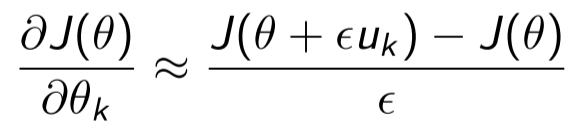

<img src=attachment:image.png width=450>
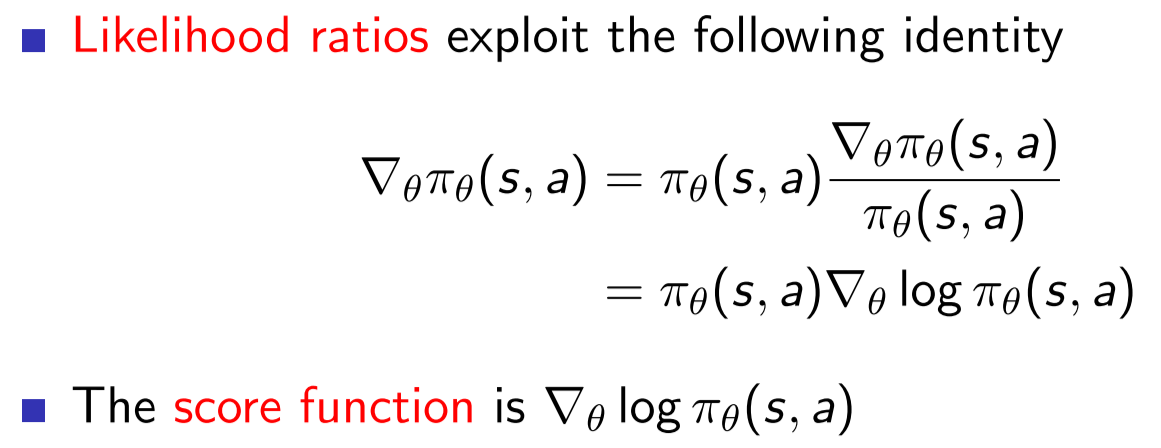

<img src=attachment:image.png width=600>
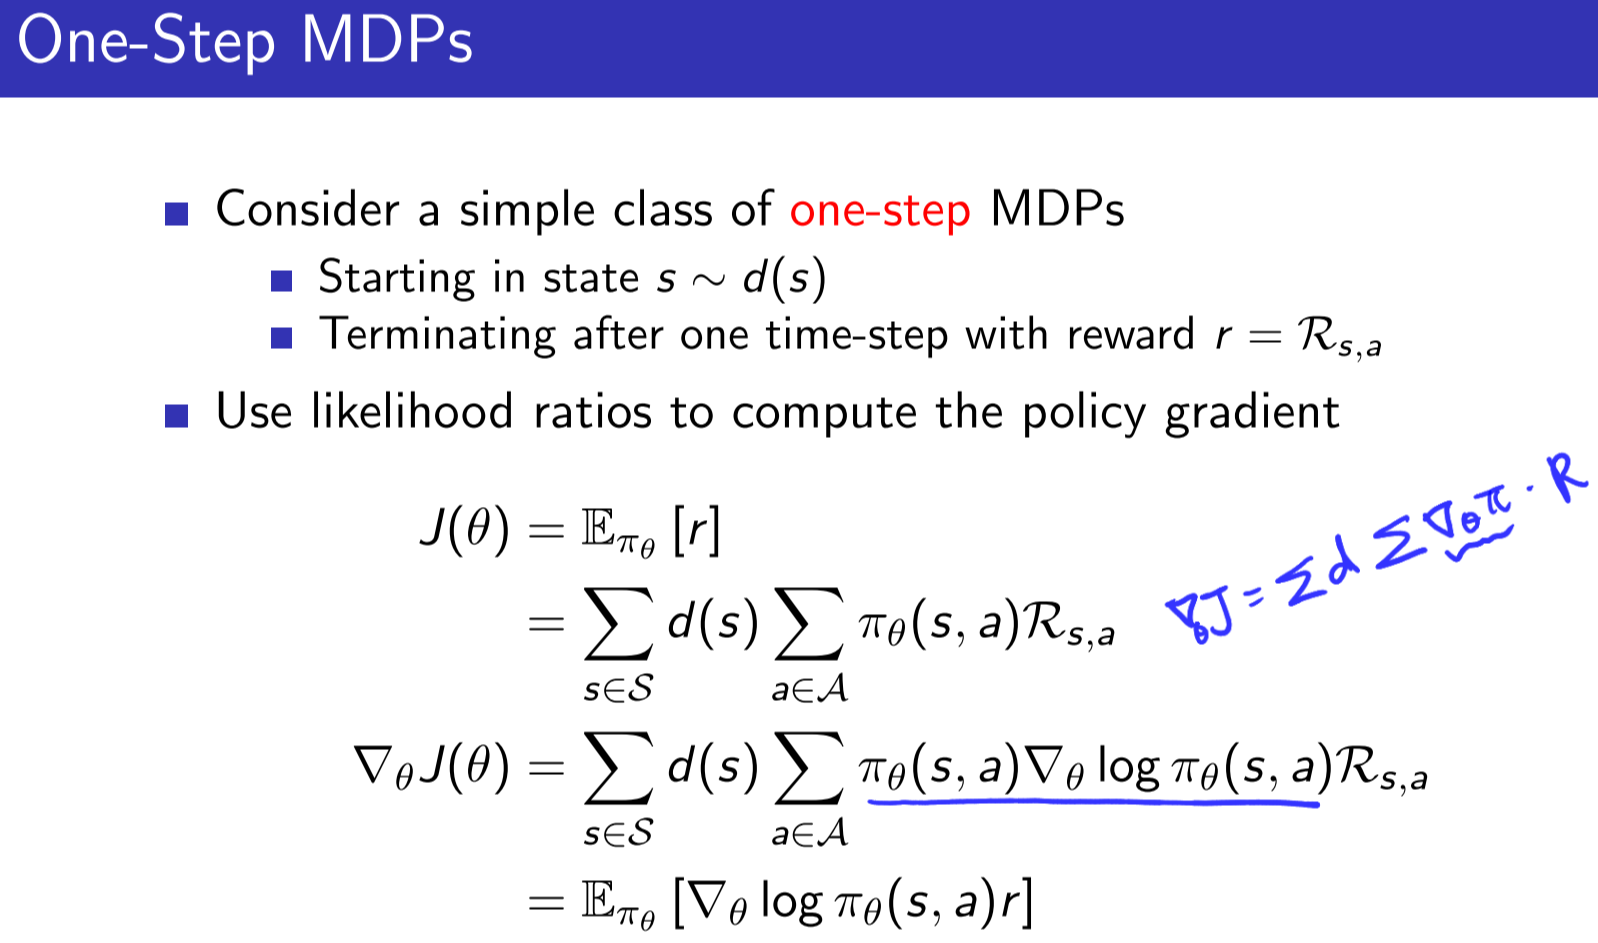

- 우선 간단하게 one step가고 reward 받고 끝나는 MDP를 고려하면, $\nabla_{\theta}J$를 위와 같이 구할 수 있음.

<img src=attachment:image.png width=550><center>Policy Gradient Theorem</center>
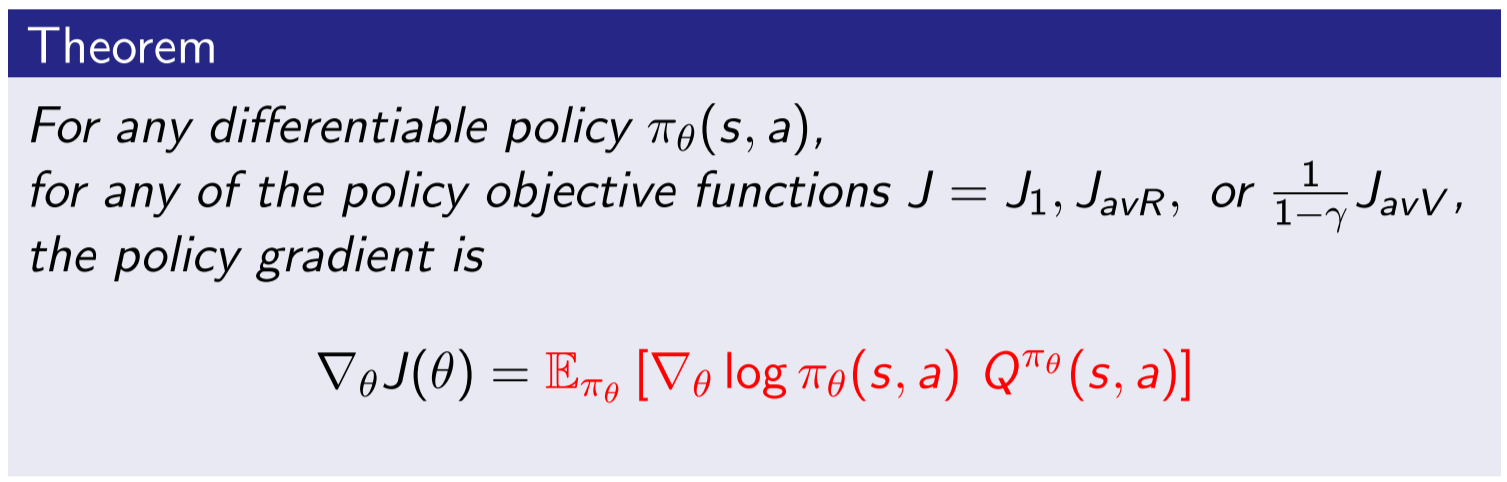

- 이를 multi-step으로 확장하면, one-step reward r 대신에 True Q(s,a)로 replace : **Policy gradient theorem**

<img src=attachment:image.png width=550><center>REINFORCE algorithm</center>
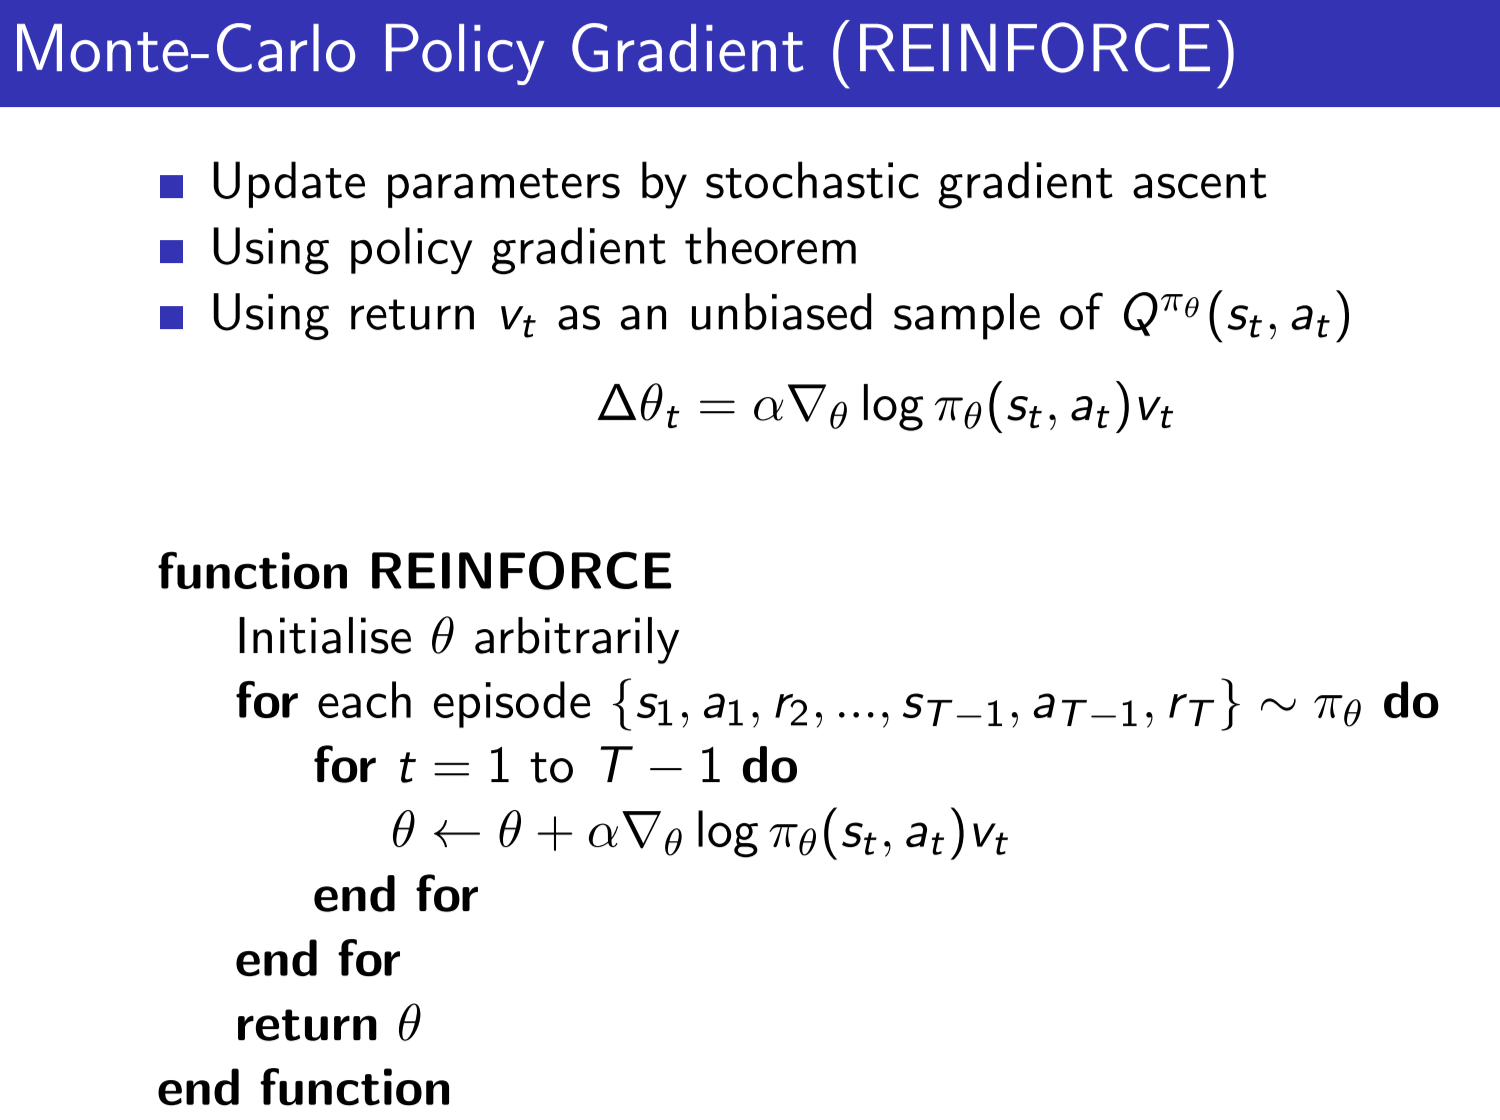

- True Q 대신에 실제로 얻은 return (unbiased estimate)을 쓰면 REINFORCE
- True Q 대신에 approximate Q network, critic을 쓰면 actor-critic

<img src=attachment:image.png width=600> 
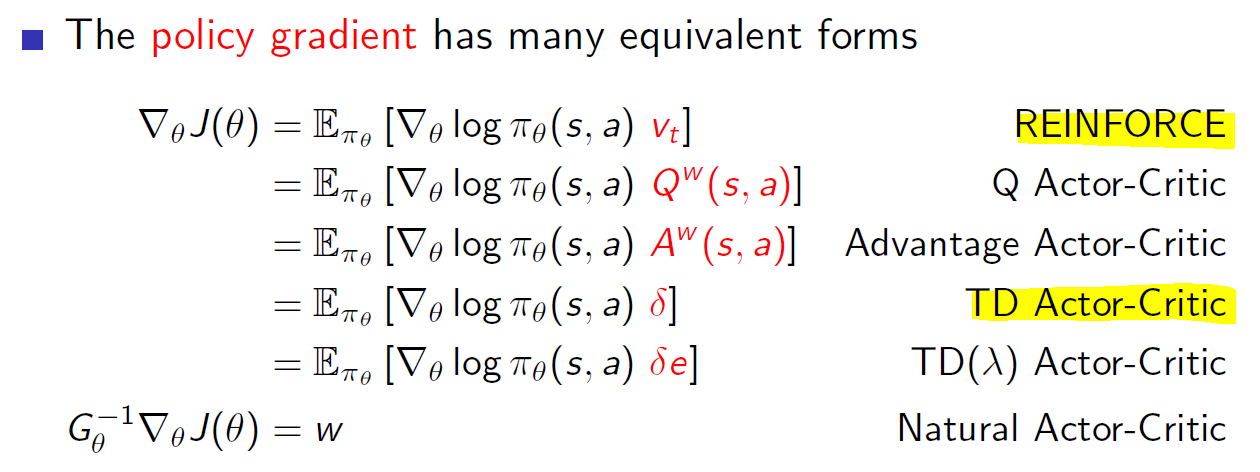

<img src=attachment:image.png width=500>
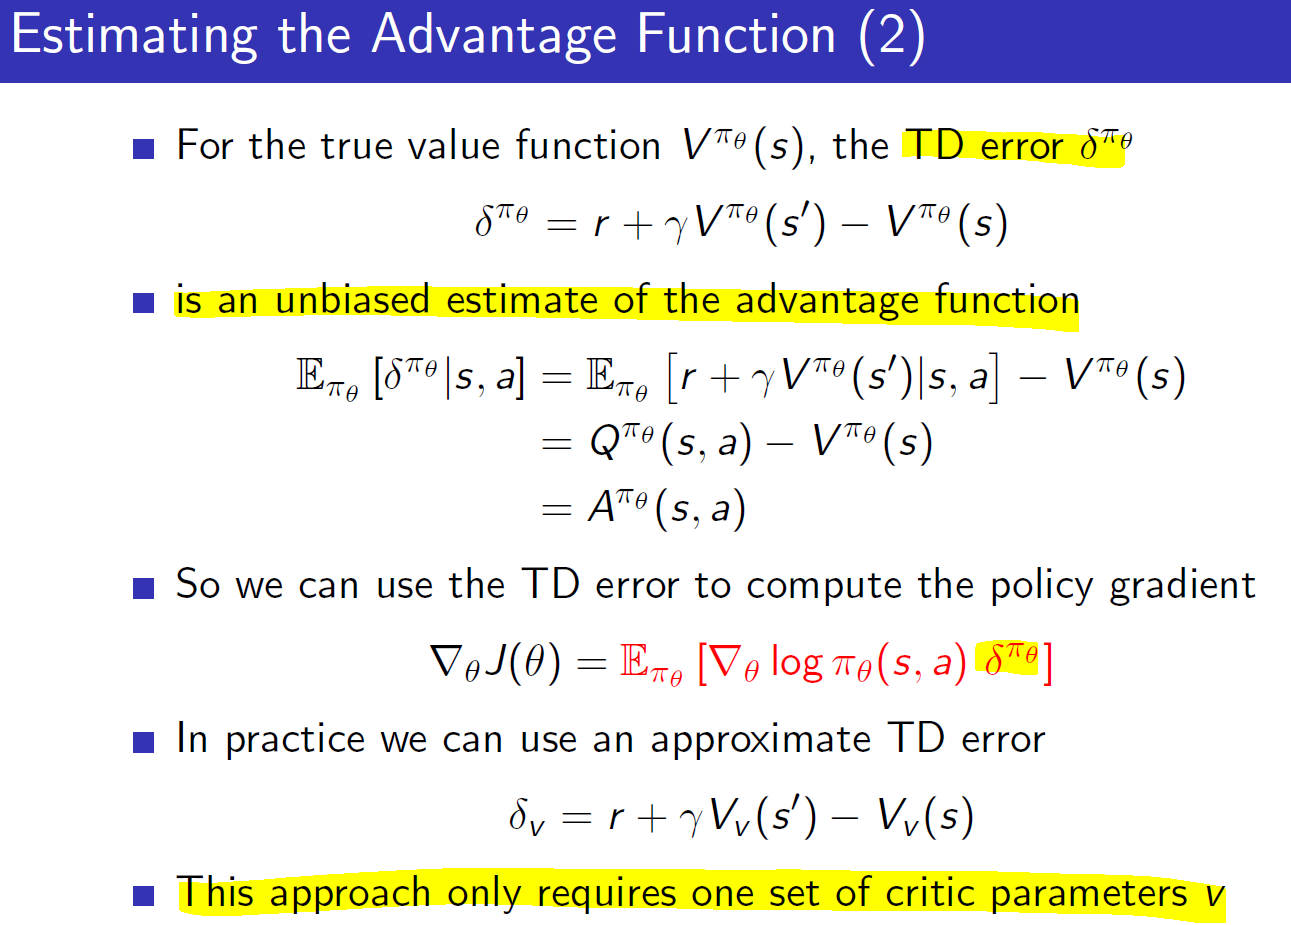

- Policy gradient implementation note.
    - $\nabla_{\theta}J = r \times \nabla_{\theta} log \pi_{\theta}(s,a)$
    - We set our loss function as $\mathcal{L} = -r\times log\pi_{\theta} (s,a)$ and minimize this. 

## REINFORCE algorithm

In [1]:
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

device = torch.device("cuda:0")

In [2]:
learning_rate = 0.0002
gamma         = 0.98

In [3]:
env = gym.make('CartPole-v1')
s = env.reset()
print(s)

[0.00334311 0.03297703 0.01627499 0.04978375]


- x : position of cart on the track
- θ : angle of the pole with the vertical
- dx/dt : cart velocity
- dθ/dt : rate of change of the angle

In [4]:
next_state, reward, terminal, info = env.step(action=0)
print('next state:{} \nreward:{} \nterminal:{}'.format(next_state, reward, terminal))

next state:[ 0.00400265 -0.16237446  0.01727066  0.34755681] 
reward:1.0 
terminal:False


In [5]:
class Policy(nn.Module):
    def __init__(self):
        super(Policy, self).__init__()
        self.data = []
        
        self.fc1 = nn.Linear(4, 128)
        self.fc2 = nn.Linear(128, 2)
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)
        
    def forward(self, x):
        out = F.relu(self.fc1(x))
        out = F.softmax(self.fc2(out), dim=0)
        return out
      
    def put_data(self, item):
        self.data.append(item)
        
    def train_net(self):
        R = 0
        for r, log_prob in self.data[::-1]:  #역순으로 계산해야 매 step마다 return 계산 용이. 
            R = r + gamma * R
            loss = -log_prob * R
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
        self.data = [] 

In [6]:
policy = Policy()
prob = policy(torch.FloatTensor(next_state))
print(prob)

tensor([0.5627, 0.4373], grad_fn=<SoftmaxBackward>)


In [7]:
policy = Policy().to(device)
score = 0.0

print_interval=100

for n_epi in range(1500):
    s = env.reset()
    for t in range(501): # collect trajectory from a episode
        prob = policy(torch.FloatTensor(s).to(device))
        m = Categorical(prob)
        a = m.sample()
        s_prime, reward, done, _ = env.step(a.item())
        policy.put_data((reward, torch.log(prob[a])))

        s = s_prime
        score += reward
        if done:
            break

    policy.train_net()

    if n_epi%print_interval==0 and n_epi!=0:
        print("episode:{}, avg score:{}".format(n_epi, score/print_interval))
        score = 0.0
env.close()

episode:100, avg score:36.07
episode:200, avg score:81.49
episode:300, avg score:186.53
episode:400, avg score:257.93
episode:500, avg score:383.29
episode:600, avg score:369.71
episode:700, avg score:190.33
episode:800, avg score:445.99
episode:900, avg score:346.55
episode:1000, avg score:394.48
episode:1100, avg score:500.0
episode:1200, avg score:264.14
episode:1300, avg score:181.97
episode:1400, avg score:314.39
